In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('home/Airline_data.csv')
data.head()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
0,1976,24,734,3863.0
1,1977,25,516,4300.0
2,1978,31,754,5027.0
3,1979,31,877,5481.0
4,1980,22,814,5814.0


In [3]:
list(data.columns)

['Year', 'Fatal accidents', 'Passenger deaths', 'Miles flown [100 mln miles]']

In [4]:
data.describe()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
count,10.00000,10.000000,10.000000,10.000000
mean,1980.50000,23.800000,691.900000,5715.800000
std,3.02765,4.709329,252.389228,1117.767795
min,1976.00000,16.000000,223.000000,3863.000000
25%,1978.25000,21.250000,570.500000,5140.500000
50%,1980.50000,23.000000,759.000000,5845.500000
75%,1982.75000,25.750000,812.750000,6175.500000
max,1985.00000,31.000000,1066.000000,7433.000000


In [5]:
%%writefile home/lab5_prior.stan
generated quantities {
    real alpha = normal_rng(2.5, 1);
    real theta = normal_rng(0.05, 0.01);
    real n = normal_rng(0, 1);
    real lambda = exp(alpha + theta * n);
    real accidents = poisson_rng(lambda);
}

Overwriting home/lab5_prior.stan


In [6]:
model_ppc=CmdStanModel(stan_file='home/lab5_prior.stan')

INFO:cmdstanpy:compiling stan file /home/lab5_prior.stan to exe file /home/lab5_prior
INFO:cmdstanpy:compiled model executable: /home/lab5_prior


In [7]:
R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=1,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [8]:
df = sim.draws_pd()
df.head()

,lp__,accept_stat__,alpha,theta,n,lambda,accidents
0,0.0,0.0,5.208170,0.057772,-1.272270,169.808000,181.0
1,0.0,0.0,-0.064034,0.065516,-0.362245,0.915974,2.0
2,0.0,0.0,3.243490,0.056560,0.230099,25.958600,30.0
3,0.0,0.0,1.508710,0.068121,-1.280310,4.143290,5.0
4,0.0,0.0,2.719640,0.065748,-0.161771,15.014200,10.0


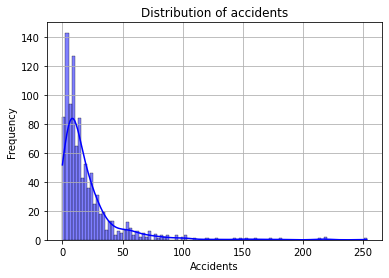

In [9]:
sns.histplot(data=df, x='accidents', bins=100, color='blue', kde=True) # If kde=True, compute a kernel density estimate to smooth the distribution
#df['accidents'].hist(bins=100, density=True)
plt.ylabel("Frequency")
plt.xlabel("Accidents")
plt.title(f"Distribution of accidents")
plt.grid(True)
plt.show()

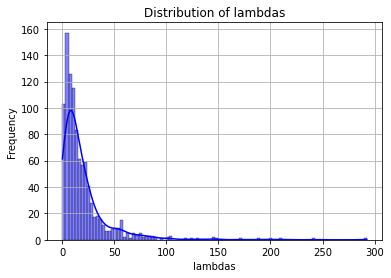

In [10]:
sns.histplot(data=df, x='lambda', bins=100, color='blue', kde=True)
#df['accidents'].hist(bins=100, density=True)
plt.ylabel("Frequency")
plt.xlabel("lambdas")
plt.title(f"Distribution of lambdas")
plt.grid(True)
plt.show()

In [11]:
%%writefile home/lab5_fit.stan
data {
    int<lower=0> N;
    array [N] int<lower=0> accidents;
    vector [N] miles;
}

parameters {
    real alpha;
    real theta;
}

transformed parameters {
    array [N] real lambda;
    for (i in 1:N) {
        lambda[i] = exp(alpha + theta * miles[i]);
    }
}

model {
    alpha ~ normal(2.5, 1);
    theta ~ normal(0.5, 0.1);

    for (i in 1:N) {
        accidents[i] ~ poisson(lambda[i]);
    }
}

generated quantities {
    array [N] int accidents_pred;
    for (i in 1:N) {
        accidents_pred[i] = poisson_rng(lambda[i]);
    }
}


Overwriting home/lab5_fit.stan


In [12]:
fit_model=CmdStanModel(stan_file='home/lab5_fit.stan')

INFO:cmdstanpy:compiling stan file /home/lab5_fit.stan to exe file /home/lab5_fit
INFO:cmdstanpy:compiled model executable: /home/lab5_fit


In [13]:
data_fit = {'N': len(data), 'accidents': data['Fatal accidents'], 'miles': data['Miles flown [100 mln miles]']}
sim=fit_model.sample(data=data_fit, iter_sampling=1000, chains=4, seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)




chain 1 |█████████ | 00:01 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [14]:
fit = sim.draws_pd()
fit.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,theta,lambda[1],...,accidents_pred[1],accidents_pred[2],accidents_pred[3],accidents_pred[4],accidents_pred[5],accidents_pred[6],accidents_pred[7],accidents_pred[8],accidents_pred[9],accidents_pred[10]
0,504.201,0.883010,0.003873,2.0,3.0,0.0,-503.396,3.84783,-0.000114,30.1670,...,28.0,32.0,27.0,20.0,24.0,17.0,25.0,18.0,11.0,16.0
1,504.209,0.999894,0.003873,5.0,35.0,0.0,-504.179,3.84187,-0.000113,30.1211,...,37.0,24.0,29.0,28.0,24.0,19.0,19.0,23.0,21.0,21.0
2,503.541,0.950009,0.003873,7.0,191.0,0.0,-503.155,3.95209,-0.000149,29.2942,...,25.0,25.0,34.0,28.0,27.0,23.0,24.0,16.0,14.0,18.0
3,503.896,0.968505,0.003873,7.0,211.0,0.0,-502.783,3.90350,-0.000138,29.1464,...,22.0,34.0,19.0,19.0,21.0,31.0,20.0,25.0,21.0,26.0
4,503.799,0.837145,0.003873,7.0,147.0,0.0,-502.121,4.00060,-0.000142,31.5545,...,36.0,32.0,25.0,25.0,30.0,26.0,20.0,21.0,15.0,21.0


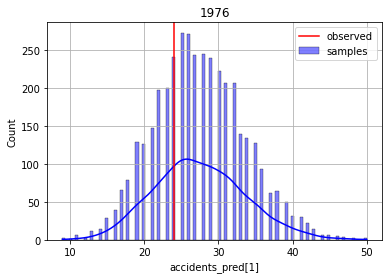

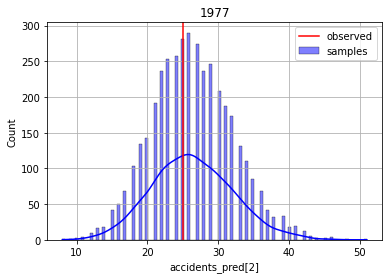

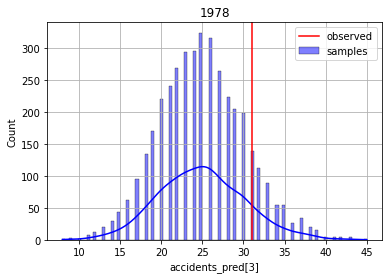

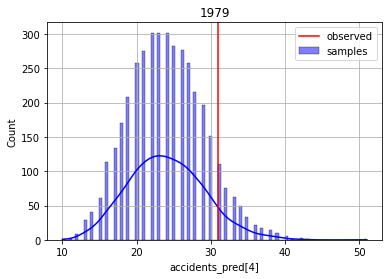

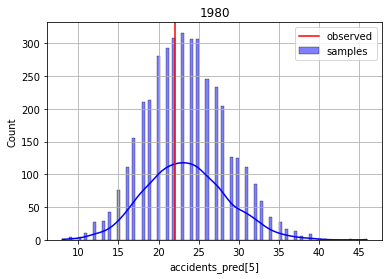

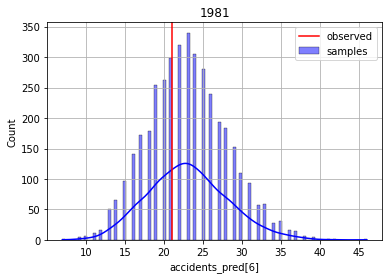

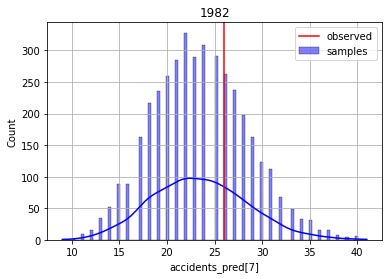

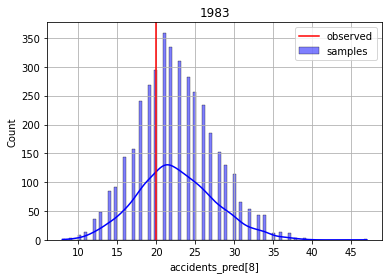

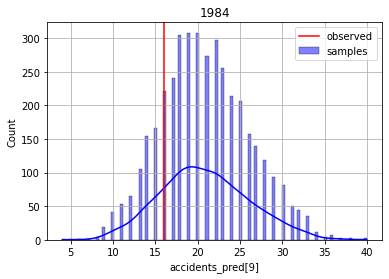

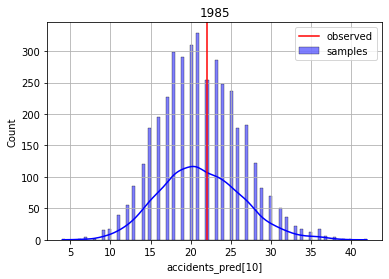

In [15]:
accidents_pred = fit.loc[:, 'accidents_pred[1]':'accidents_pred[10]']
years = data['Year']
observed_fatal_accidents = data['Fatal accidents']
for i in range(len(data)):
    sns.histplot(data=accidents_pred, x=f'accidents_pred[{i+1}]', bins=100, color='blue', kde=True, label='samples')
    plt.axvline(observed_fatal_accidents[i], color='r', label='observed')
    plt.title(f"{years[i]}")
    plt.legend()
    plt.grid()
    plt.show()


In [16]:
%%writefile home/lab5_fit_alpha_i.stan
data {
    int<lower=0> N;
    array [N] int<lower=0> accidents;
    vector [N] miles;
}

parameters {
    array [N] real alpha_i;
    real theta;
}

transformed parameters {
    array [N] real lambda;
    for (i in 1:N) {
        lambda[i] = exp(alpha_i[i] + theta * miles[i]);
    }
}

model {
    alpha_i ~ normal(2.5, 1);
    theta ~ normal(0.5, 0.1);

    for (i in 1:N) {
        accidents[i] ~ poisson(lambda[i]);
    }
}

generated quantities {
    array [N] int accidents_pred;
    for (i in 1:N) {
        accidents_pred[i] = poisson_rng(lambda[i]);
    }
}


Overwriting home/lab5_fit_alpha_i.stan


In [17]:
fit_model_alpha_i=CmdStanModel(stan_file='home/lab5_fit_alpha_i.stan')

INFO:cmdstanpy:compiling stan file /home/lab5_fit_alpha_i.stan to exe file /home/lab5_fit_alpha_i
INFO:cmdstanpy:compiled model executable: /home/lab5_fit_alpha_i


In [18]:
data_fit = {'N': len(data), 'accidents': data['Fatal accidents'], 'miles': data['Miles flown [100 mln miles]']}
sim=fit_model_alpha_i.sample(data=data_fit, iter_sampling=1000, chains=4, seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |███████▎  | 00:04 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |███████▋  | 00:04 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |████████▏ | 00:05 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:06 Sampling completed                       
chain 2 |██████████| 00:06 Sampling completed                       
chain 3 |██████████| 00:06 Sa


INFO:cmdstanpy:CmdStan done processing.


In [19]:
fit_alpha = sim.draws_pd()
fit_alpha.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha_i[1],alpha_i[2],alpha_i[3],...,accidents_pred[1],accidents_pred[2],accidents_pred[3],accidents_pred[4],accidents_pred[5],accidents_pred[6],accidents_pred[7],accidents_pred[8],accidents_pred[9],accidents_pred[10]
0,503.320,0.994714,0.003369,10.0,1023.0,0.0,-496.302,2.27272,2.49566,2.22128,...,19.0,35.0,19.0,32.0,22.0,39.0,20.0,17.0,24.0,30.0
1,501.691,0.999869,0.003369,10.0,1023.0,0.0,-499.923,2.41099,2.56511,2.55326,...,29.0,38.0,53.0,26.0,23.0,30.0,24.0,23.0,7.0,22.0
2,504.500,0.994046,0.003369,10.0,1023.0,0.0,-497.131,2.45585,2.56084,2.63213,...,29.0,28.0,33.0,28.0,15.0,14.0,29.0,31.0,17.0,15.0
3,504.904,0.659343,0.003369,10.0,1023.0,0.0,-496.888,2.26558,2.42484,2.45647,...,27.0,26.0,39.0,24.0,27.0,24.0,49.0,26.0,15.0,23.0
4,503.652,0.998294,0.003369,10.0,1023.0,0.0,-499.569,2.45065,2.32318,2.24355,...,23.0,24.0,20.0,45.0,24.0,20.0,26.0,19.0,21.0,30.0


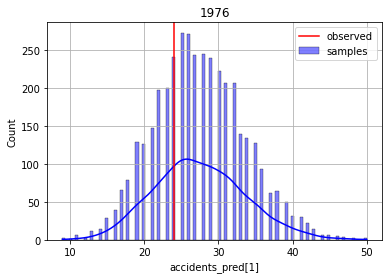

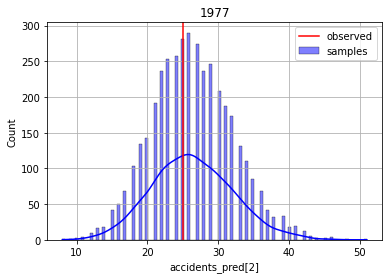

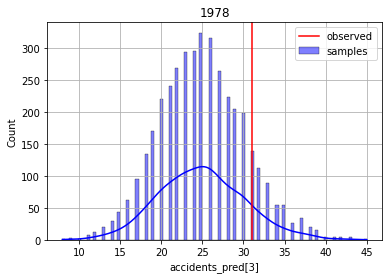

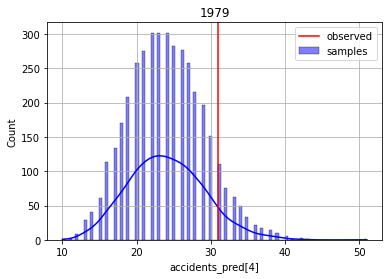

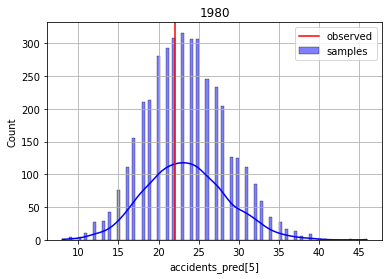

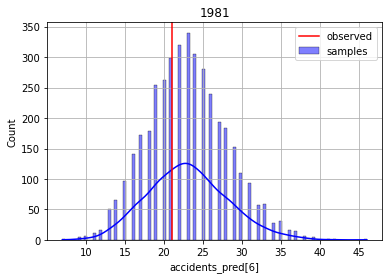

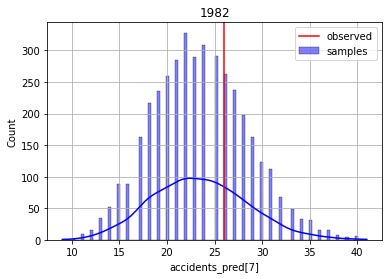

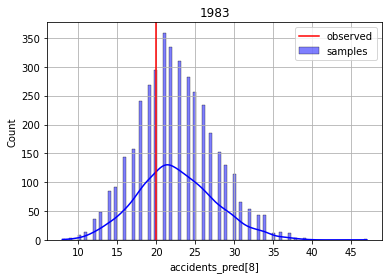

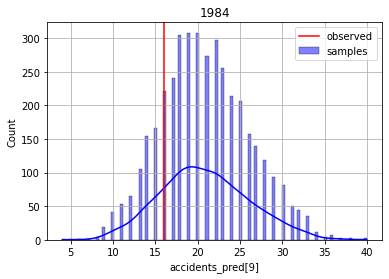

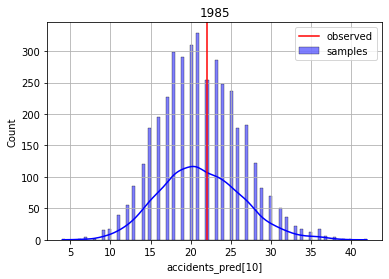

In [20]:
accidents_pred = fit.loc[:, 'accidents_pred[1]':'accidents_pred[10]']
years = data['Year']
observed_fatal_accidents = data['Fatal accidents']
for i in range(len(data)):
    sns.histplot(data=accidents_pred, x=f'accidents_pred[{i+1}]', bins=100, color='blue', kde=True, label='samples')
    plt.axvline(observed_fatal_accidents[i], color='r', label='observed')
    plt.title(f"{years[i]}")
    plt.legend()
    plt.grid()
    plt.show()